In [1]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import classification_report
import keras
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet152
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.metrics import confusion_matrix


drive.mount('/content/drive/')


Mounted at /content/drive/


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
#datagen.fit(x_train)


In [4]:
path = "/content/drive/MyDrive/paru/data"
# Ukuran gambar sesuai dengan input VGG19
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Penyesuaian batch size
BATCH_SIZE = 64

# Pengaturan generator gambar dengan rescale untuk val dan test
datagen_val_test = ImageDataGenerator(rescale=1.0 / 255)

traindata = ImageDataGenerator().flow_from_directory(
    path+'/train',
    seed=123,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

testdata = ImageDataGenerator().flow_from_directory(
    path+"/test",
    seed=123,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = ImageDataGenerator().flow_from_directory(
    path+"/valid",
    seed=123,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Melihat urutan kelas yang digunakan
class_indices = traindata.class_indices
print(class_indices)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
{'adenocarcinoma': 0, 'large cell carcinoma': 1, 'normal': 2, 'squamous cell carcinoma': 3}


In [5]:
resnet152model = ResNet152(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
resnet152model.summary()

234698864/234698864 [==============================] - 2s 0us/step
Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                   

In [6]:
#base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layers in (resnet152model.layers)[:22]:
    layers.trainable = False

In [7]:
X = Flatten()(resnet152model.output)
X = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(X)
X = Dropout(0.5)(X)
X = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(X)
X = Dropout(0.5)(X)
predictions = Dense(4, activation='softmax')(X)

model_final = Model(inputs=resnet152model.input, outputs=predictions)

In [8]:
from tensorflow.keras.optimizers import Adam
from keras import optimizers

model_final.compile(
    loss='categorical_crossentropy',  # Menggunakan 'categorical_crossentropy' untuk klasifikasi multi-kelas
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Menggunakan optimizer Adam dengan learning rate yang lebih tinggi
    metrics=['accuracy']
)



In [9]:
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [10]:
checkpoint = ModelCheckpoint(
    path + "/ResNet152_model_best.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False
)
early = EarlyStopping(

    monitor='val_accuracy',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto'
)


In [11]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.1

lr_scheduler = LearningRateScheduler(scheduler)


In [12]:
hist = model_final.fit(
    traindata,
    epochs=30,
    validation_data=val_data,
    steps_per_epoch=traindata.samples // BATCH_SIZE,
    validation_steps=val_data.samples // BATCH_SIZE,
    callbacks=[checkpoint, early]
)

model_final.save(path + "/ResNet152_model_final.h5")

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 4.0404 - accuracy: 0.4845 
Epoch 1: val_accuracy improved from -inf to 0.51562, saving model to /content/drive/MyDrive/paru/data/ResNet152_model_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 301s 21s/step - loss: 4.0404 - accuracy: 0.4845 - val_loss: 3.5156 - val_accuracy: 0.5156
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 2.5180 - accuracy: 0.7177
Epoch 2: val_accuracy improved from 0.51562 to 0.65625, saving model to /content/drive/MyDrive/paru/data/ResNet152_model_best.h5
9/9 [==============================] - 46s 5s/step - loss: 2.5180 - accuracy: 0.7177 - val_loss: 2.4914 - val_accuracy: 0.6562
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 1.8242 - accuracy: 0.8525
Epoch 3: val_accuracy did not improve from 0.65625
9/9 [==============================] - 16s 2s/step - loss: 1.8242 - accuracy: 0.8525 - val_loss: 2.7607 - val_accuracy: 0.6406
Epoch 4/30
9/9 [==============================] - ETA: 0s - loss: 1.6322 - accuracy: 0.9132
Epoch 4: val_accuracy improved from 0.65625 to 0.84375, saving model to /content/drive/MyDrive/paru/data/ResNet152_model_best.h5
9/9 [===========================

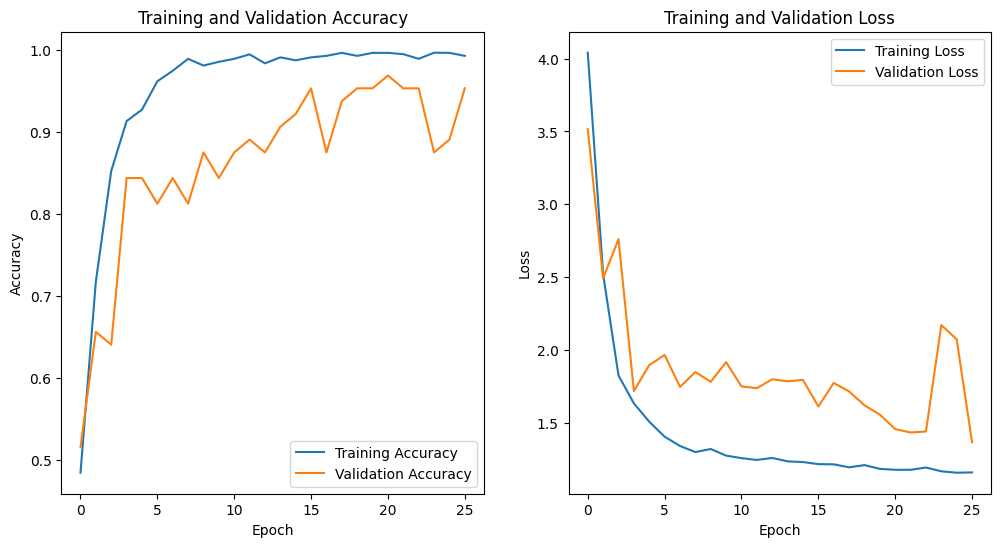

In [13]:
# Plotting training and validation accuracy and loss
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


2/2 [==============================] - 5s 2s/step
                         precision    recall  f1-score   support

         adenocarcinoma       0.96      0.96      0.96        23
   large cell carcinoma       1.00      0.95      0.98        21
                 normal       1.00      1.00      1.00        13
squamous cell carcinoma       0.94      1.00      0.97        15

               accuracy                           0.97        72
              macro avg       0.97      0.98      0.97        72
           weighted avg       0.97      0.97      0.97        72



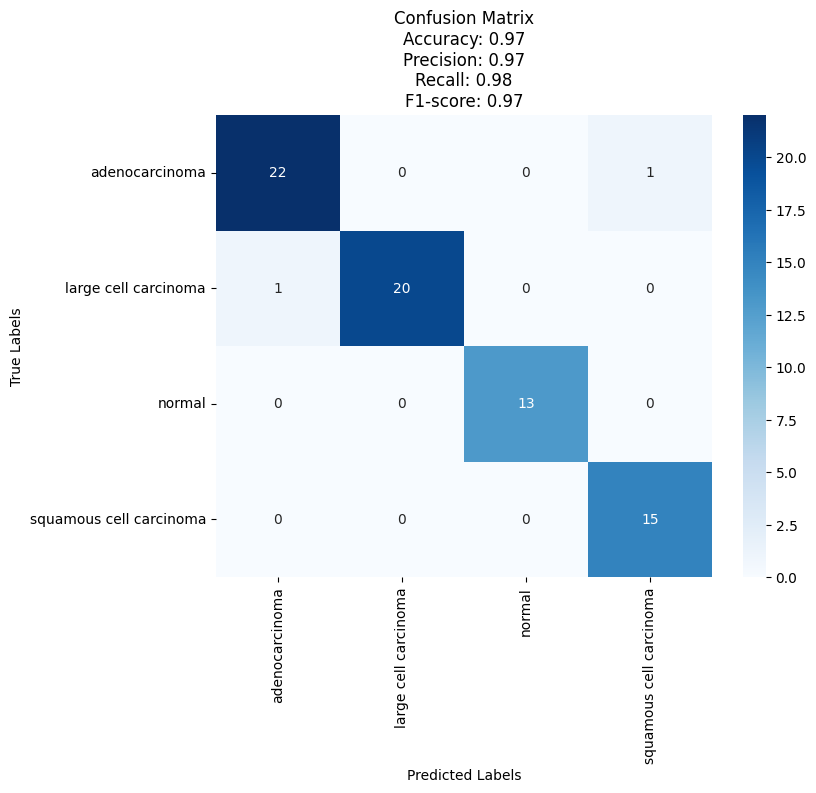

In [14]:
from sklearn.metrics import classification_report
from keras.models import load_model
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

best_model_path = path + '/ResNet152_model_best.h5'
model_final = load_model(best_model_path)

pred = model_final.predict(val_data)
predictions = np.argmax(pred, axis=-1)

print(classification_report(val_data.classes, predictions, target_names=list(val_data.class_indices.keys())))

cm = confusion_matrix(val_data.classes, predictions)
class_labels = list(val_data.class_indices.keys())

report = classification_report(val_data.classes, predictions, target_names=class_labels, output_dict=True)
accuracy = report['accuracy']
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix\nAccuracy: {:.2f}\nPrecision: {:.2f}\nRecall: {:.2f}\nF1-score: {:.2f}'.format(accuracy, precision, recall, f1_score))
plt.show()


codingan dari cica adeno-normal semua gambar terbaca dengan benar, squamous gambar itu saja

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 3s 3s/step


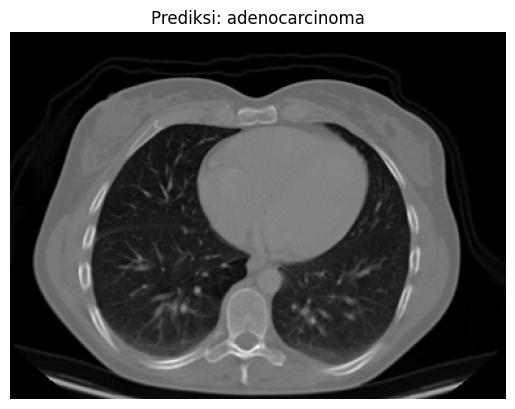

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from google.colab import drive

# Mount Google Drive untuk mengakses file model
drive.mount('/content/drive')

# Path ke model yang sudah disimpan
model_path = "/content/drive/MyDrive/paru/data/ResNet152_model_best.h5"

# Muat model yang sudah dilatih
model = load_model(model_path)

# Fungsi untuk memproses gambar
def prepare_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Daftar label kelas
class_labels = ['adenocarcinoma', 'large cell carcinoma', 'normal', 'squamous cell carcinoma']

# Fungsi untuk memprediksi kelas gambar
def predict_image_class(img_path):
    img_array = prepare_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_labels[predicted_class[0]]

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Prediksi: {predicted_label}')
    plt.axis('off')
    plt.show()

    return predicted_label

# Path ke gambar yang akan diuji
image_path = "/content/drive/MyDrive/paru/data/test/adenocarcinoma/000108 (3).png"

# Prediksi kelas gambar
predicted_label = predict_image_class(image_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 3s 3s/step


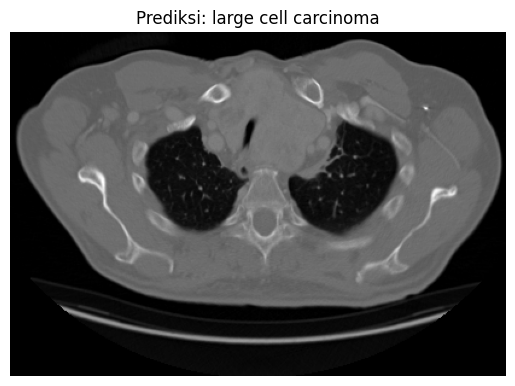

Gambar diklasifikasikan sebagai: large cell carcinoma


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from google.colab import drive

# Mount Google Drive untuk mengakses file model
drive.mount('/content/drive')

# Path ke model yang sudah disimpan
model_path = "/content/drive/MyDrive/paru/data/ResNet152_model_best.h5"

# Muat model yang sudah dilatih
model = load_model(model_path)

# Fungsi untuk memproses gambar
def prepare_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Daftar label kelas
class_labels = ['adenocarcinoma', 'large cell carcinoma', 'normal', 'squamous cell carcinoma']

# Fungsi untuk memprediksi kelas gambar
def predict_image_class(img_path):
    img_array = prepare_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_labels[predicted_class[0]]

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Prediksi: {predicted_label}')
    plt.axis('off')
    plt.show()

    return predicted_label

# Path ke gambar yang akan diuji
image_path = "/content/drive/MyDrive/paru/data/test/large.cell.carcinoma/000108.png"

# Prediksi kelas gambar
predicted_label = predict_image_class(image_path)
print(f'Gambar diklasifikasikan sebagai: {predicted_label}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 [==============================] - 3s 3s/step


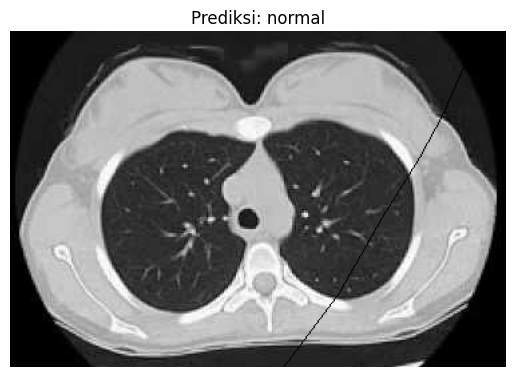

Gambar diklasifikasikan sebagai: normal


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from google.colab import drive

# Mount Google Drive untuk mengakses file model
drive.mount('/content/drive')

# Path ke model yang sudah disimpan
model_path = "/content/drive/MyDrive/paru/data/ResNet152_model_best.h5"

# Muat model yang sudah dilatih
model = load_model(model_path)

# Fungsi untuk memproses gambar
def prepare_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Daftar label kelas
class_labels = ['adenocarcinoma', 'large cell carcinoma', 'normal', 'squamous cell carcinoma']

# Fungsi untuk memprediksi kelas gambar
def predict_image_class(img_path):
    img_array = prepare_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_labels[predicted_class[0]]

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Prediksi: {predicted_label}')
    plt.axis('off')
    plt.show()

    return predicted_label

# Path ke gambar yang akan diuji
image_path = "/content/drive/MyDrive/paru/data/test/normal/10 (2) - Copy.png"

# Prediksi kelas gambar
predicted_label = predict_image_class(image_path)
print(f'Gambar diklasifikasikan sebagai: {predicted_label}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1/1 [==============================] - 3s 3s/step


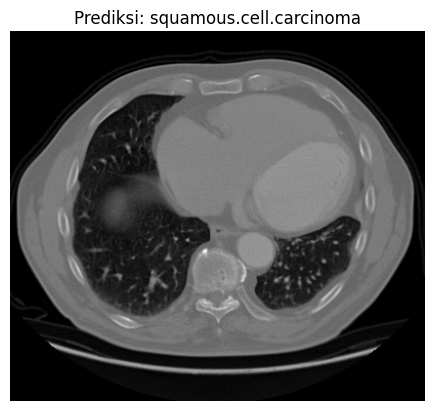

Gambar diklasifikasikan sebagai: squamous.cell.carcinoma


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from google.colab import drive

# Mount Google Drive untuk mengakses file model
drive.mount('/content/drive')

# Path ke model yang sudah disimpan
model_path = "/content/drive/MyDrive/paru/data/ResNet152_model_best.h5"

# Muat model yang sudah dilatih
model = load_model(model_path)

# Fungsi untuk memproses gambar
def prepare_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Daftar label kelas
class_labels = ['adenocarcinoma', 'large cell carcinoma', 'normal', 'squamous.cell.carcinoma']

# Fungsi untuk memprediksi kelas gambar
def predict_image_class(img_path):
    img_array = prepare_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_labels[predicted_class[0]]

    # Menampilkan gambar dan hasil prediksi
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Prediksi: {predicted_label}')
    plt.axis('off')
    plt.show()

    return predicted_label

# Path ke gambar yang akan diuji
image_path = "/content/drive/MyDrive/paru/data/test/squamous.cell.carcinoma/000172 (6).png"

# Prediksi kelas gambar
predicted_label = predict_image_class(image_path)
print(f'Gambar diklasifikasikan sebagai: {predicted_label}')